In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import fastai
import fastai.tabular
from fastai.vision.all import *
from fastai.data.core import DataLoaders
from CNN import *
import random, os, h5py, json

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open("data_config.json", "r") as outfile:
    data = json.load(outfile, strict=False)
    
extent = list(data['extent'])
data_numpy = np.load('data.npy')
num_sim, split, batch_size = 100, 0.95, 8192
n_epochs = 35 #number found from lr_finder nb
d = 48
save_models = True

indices = [i for i in range(num_sim)]
random.shuffle(indices)

train_data = CustomDataset(data_numpy, indices[:int(split * num_sim)], device)
val_data = CustomDataset(data_numpy, indices[int(split * num_sim):], device)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

Selected device: cuda


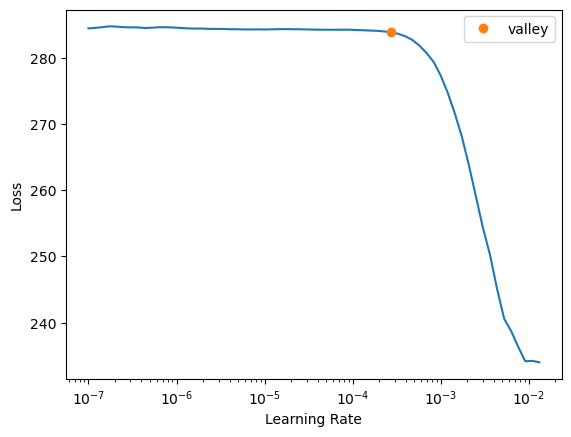

In [7]:
autoenc = AutoEncoder(d).to(device)
dls = DataLoaders.from_dsets(train_data, val_data, bs = batch_size)
learn = Learner(dls, autoenc, loss_func = F.mse_loss)
lr = learn.lr_find().valley

epoch,train_loss,valid_loss,time
0,284.214661,285.700378,00:18
1,283.475342,282.870972,00:20
2,276.011780,248.895691,00:20
3,236.651031,140.998444,00:20
4,170.943390,65.229820,00:20
5,117.457031,43.895191,00:20
6,82.804794,35.470448,00:20
7,60.538708,29.809923,00:19
8,46.613724,27.733112,00:20
9,38.109119,26.634241,00:20


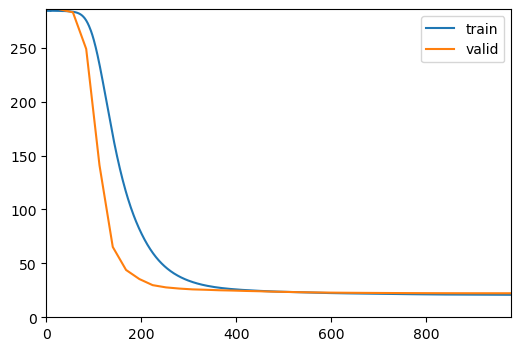

In [8]:
#Training
learn.fit_one_cycle(n_epochs, lr, cbs=[ShowGraphCallback()])

In [5]:
if save_models:
    save_model(f'model/d_{d}_epoch_{n_epochs}.pkl', learn, learn.opt)
    file = open(f'model/indices_d_{d}_epoch_{n_epochs}.txt','w')
    file.write(str(split)+" ")
    for item in indices:
        file.write(str(item)+" ")
    file.close()

In [ ]:
#Validation loss
valid_loss = learn.validate()[0]
%store valid_loss